# Complete MMM Analysis - Model Training and Evaluation

This notebook continues the MMM analysis with model training, cross-validation, and business insights.

In [1]:
# Import required libraries and define variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Define channel groups and variables
social_channels = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
mediator_channel = 'google_spend'
outcome_variable = 'revenue'
control_variables = ['social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send']
seasonality_features = ['month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']

print("Channel Structure:")
print(f"Social Channels (X): {social_channels}")
print(f"Mediator (M): {mediator_channel}")
print(f"Outcome (Y): {outcome_variable}")
print(f"Controls: {control_variables}")
print(f"Seasonality: {seasonality_features}")

# Load the processed data (assuming it exists from previous analysis)
try:
    df_processed = pd.read_csv('../data/processed_data.csv')
    df_processed['week'] = pd.to_datetime(df_processed['week'])
    print(f"Loaded processed data with shape: {df_processed.shape}")
except FileNotFoundError:
    print("Processed data not found. Please run the main MMM_Analysis.ipynb first.")
    # Load and process raw data as fallback
    df = pd.read_csv('../data/Assessment 2 - MMM Weekly.csv')
    df['week'] = pd.to_datetime(df['week'])
    df_processed = df.copy()
print(f"Loaded raw data with shape: {df_processed.shape}")

Channel Structure:
Social Channels (X): ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
Mediator (M): google_spend
Outcome (Y): revenue
Controls: ['social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send']
Seasonality: ['month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']
Processed data not found. Please run the main MMM_Analysis.ipynb first.
Loaded raw data with shape: (104, 12)


In [2]:
# Define transformation functions
def adstock_transform(x, decay_rate):
    """Apply adstock transformation to capture carryover effects"""
    adstocked = np.zeros_like(x)
    adstocked[0] = x[0]
    for i in range(1, len(x)):
        adstocked[i] = x[i] + decay_rate * adstocked[i-1]
    return adstocked

def saturation_transform(x, alpha, gamma):
    """Apply saturation transformation using Hill transformation"""
    return alpha * (x ** gamma) / (alpha ** gamma + x ** gamma)

def transform_media(x, decay_rate, alpha, gamma):
    """Apply both adstock and saturation transformations"""
    adstocked = adstock_transform(x, decay_rate)
    saturated = saturation_transform(adstocked, alpha, gamma)
    return saturated

# MediationAnalysis class
class MediationAnalysis:
    def __init__(self, X, M, Y, controls=None):
        self.X = X
        self.M = M
        self.Y = Y
        self.controls = controls if controls is not None else []
        self.results = {}
    
    def fit_path_models(self):
        # Path a: X -> M
        X_with_controls = np.column_stack([self.X] + self.controls) if self.controls else self.X
        X_with_controls = sm.add_constant(X_with_controls)
        self.model_a = sm.OLS(self.M, X_with_controls).fit()
        
        # Path b: M -> Y
        XM_with_controls = np.column_stack([self.X, self.M] + self.controls) if self.controls else np.column_stack([self.X, self.M])
        XM_with_controls = sm.add_constant(XM_with_controls)
        self.model_b = sm.OLS(self.Y, XM_with_controls).fit()
        
        # Path c: X -> Y
        self.model_c = sm.OLS(self.Y, X_with_controls).fit()
        return self
    
    def calculate_effects(self):
        a_coef = self.model_a.params[1]
        b_coef = self.model_b.params[-1]
        c_coef = self.model_c.params[1]
        c_prime_coef = self.model_b.params[1]
        
        indirect_effect = a_coef * b_coef
        direct_effect = c_prime_coef
        total_effect = c_coef
        prop_mediated = indirect_effect / total_effect if total_effect != 0 else 0
        
        self.results = {
            'indirect_effect': indirect_effect,
            'direct_effect': direct_effect,
            'total_effect': total_effect,
            'proportion_mediated': prop_mediated,
            'a_coefficient': a_coef,
            'b_coefficient': b_coef,
            'c_coefficient': c_coef,
            'c_prime_coefficient': c_prime_coef
        }
        return self.results
    
    def bootstrap_confidence_intervals(self, n_bootstrap=1000, alpha=0.05):
        n_samples = len(self.Y)
        bootstrap_effects = []
        
        for _ in range(n_bootstrap):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = self.X[indices]
            M_boot = self.M[indices]
            Y_boot = self.Y[indices]
            controls_boot = [ctrl[indices] for ctrl in self.controls] if self.controls else []
            
            try:
                boot_analysis = MediationAnalysis(X_boot, M_boot, Y_boot, controls_boot)
                boot_analysis.fit_path_models()
                boot_effects = boot_analysis.calculate_effects()
                bootstrap_effects.append(boot_effects['indirect_effect'])
            except:
                continue
        
        bootstrap_effects = np.array(bootstrap_effects)
        lower_ci = np.percentile(bootstrap_effects, (alpha/2) * 100)
        upper_ci = np.percentile(bootstrap_effects, (1 - alpha/2) * 100)
        
        return {
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'bootstrap_effects': bootstrap_effects
        }

print("Functions and classes defined successfully!")

# Create seasonality features
df_processed['month'] = df_processed['week'].dt.month
df_processed['quarter'] = df_processed['week'].dt.quarter
df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12)
df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12)
df_processed['quarter_sin'] = np.sin(2 * np.pi * df_processed['quarter'] / 4)
df_processed['quarter_cos'] = np.cos(2 * np.pi * df_processed['quarter'] / 4)

print("Seasonality features created successfully!")
print(f"Dataset shape after adding seasonality: {df_processed.shape}")

# Apply transformations to media channels
print("Applying media transformations...")
for channel in social_channels + [mediator_channel]:
    if channel in df_processed.columns:
        # Use simple transformation parameters for now
        decay_rate = 0.5
        alpha = 1.0
        gamma = 0.5
        
        transformed_col = f"{channel}_transformed"
        df_processed[transformed_col] = transform_media(
            df_processed[channel].values, decay_rate, alpha, gamma
        )
        print(f"Transformed {channel} -> {transformed_col}")
    else:
        print(f"Warning: {channel} not found in dataset")

print("Media transformations completed!")

Functions and classes defined successfully!
Seasonality features created successfully!
Dataset shape after adding seasonality: (104, 18)
Applying media transformations...
Transformed facebook_spend -> facebook_spend_transformed
Transformed tiktok_spend -> tiktok_spend_transformed
Transformed instagram_spend -> instagram_spend_transformed
Transformed snapchat_spend -> snapchat_spend_transformed
Transformed google_spend -> google_spend_transformed
Media transformations completed!


In [3]:
# Run mediation analysis for each social channel
mediation_results = {}

# Prepare data for mediation analysis
social_transformed = [f'{ch}_transformed' for ch in social_channels]
mediator_transformed = f'{mediator_channel}_transformed'

# Control variables (including seasonality)
control_vars = control_variables + seasonality_features
controls_data = [df_processed[var].values for var in control_vars]

print("Running mediation analysis for each social channel...")

for i, social_ch in enumerate(social_transformed):
    print(f"\nAnalyzing {social_ch}:")
    
    # Extract data
    X = df_processed[social_ch].values
    M = df_processed[mediator_transformed].values
    Y = df_processed[outcome_variable].values
    
    # Run mediation analysis
    mediation = MediationAnalysis(X, M, Y, controls_data)
    mediation.fit_path_models()
    effects = mediation.calculate_effects()
    
    # Bootstrap confidence intervals
    ci_results = mediation.bootstrap_confidence_intervals()
    
    # Store results
    mediation_results[social_ch] = {
        'effects': effects,
        'confidence_intervals': ci_results,
        'models': {
            'path_a': mediation.model_a,
            'path_b': mediation.model_b,
            'path_c': mediation.model_c
        }
    }
    
    # Print results
    print(f"  Direct effect: {effects['direct_effect']:.4f}")
    print(f"  Indirect effect: {effects['indirect_effect']:.4f}")
    print(f"  Total effect: {effects['total_effect']:.4f}")
    print(f"  Proportion mediated: {effects['proportion_mediated']:.2%}")
    print(f"  95% CI for indirect effect: [{ci_results['lower_ci']:.4f}, {ci_results['upper_ci']:.4f}]")

Running mediation analysis for each social channel...

Analyzing facebook_spend_transformed:
  Direct effect: 5656479.5627
  Indirect effect: -120387.3763
  Total effect: 5747130.6660
  Proportion mediated: -2.09%
  95% CI for indirect effect: [-740329.3199, 358528.9314]

Analyzing tiktok_spend_transformed:
  Direct effect: 155909.0812
  Indirect effect: 3253.9834
  Total effect: 151810.4005
  Proportion mediated: 2.14%
  95% CI for indirect effect: [-2073.7948, 14034.6082]

Analyzing instagram_spend_transformed:
  Direct effect: 391282.3683
  Indirect effect: -1793.2485
  Total effect: 388101.8663
  Proportion mediated: -0.46%
  95% CI for indirect effect: [-7277.1231, 2415.7181]

Analyzing snapchat_spend_transformed:
  Direct effect: 41174.4162
  Indirect effect: -8350.3416
  Total effect: 36771.4526
  Proportion mediated: -22.71%
  95% CI for indirect effect: [-20994.9743, -632.0307]


## 4. Model Training and Cross-Validation

In [4]:
# Prepare feature matrix for modeling
feature_columns = (social_transformed + [mediator_transformed] + 
                  control_variables + seasonality_features)

X_features = df_processed[feature_columns].copy()
y_target = df_processed[outcome_variable].copy()

print(f"Feature matrix shape: {X_features.shape}")
print(f"Target variable shape: {y_target.shape}")
print(f"Features: {feature_columns}")

# Handle any remaining missing values
X_features = X_features.fillna(X_features.mean())
y_target = y_target.fillna(y_target.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

Feature matrix shape: (104, 14)
Target variable shape: (104,)
Features: ['facebook_spend_transformed', 'tiktok_spend_transformed', 'instagram_spend_transformed', 'snapchat_spend_transformed', 'google_spend_transformed', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']


In [5]:
# Time series cross-validation setup
def time_series_cv_split(n_samples, n_splits=5, test_size=0.2):
    """Create time series cross-validation splits"""
    
    test_size_samples = int(n_samples * test_size)
    train_size_samples = n_samples - test_size_samples
    
    splits = []
    
    for i in range(n_splits):
        # Calculate split points
        train_end = train_size_samples - (n_splits - 1 - i) * (test_size_samples // n_splits)
        test_start = train_end
        test_end = min(test_start + test_size_samples, n_samples)
        
        train_indices = list(range(0, train_end))
        test_indices = list(range(test_start, test_end))
        
        splits.append((train_indices, test_indices))
    
    return splits

# Create CV splits
cv_splits = time_series_cv_split(len(X_scaled), n_splits=5)
print(f"Created {len(cv_splits)} time series CV splits")

# Display split information
for i, (train_idx, test_idx) in enumerate(cv_splits):
    print(f"Split {i+1}: Train size={len(train_idx)}, Test size={len(test_idx)}, Train end week={df_processed.iloc[train_idx[-1]]['week'].strftime('%Y-%m-%d')}, Test start week={df_processed.iloc[test_idx[0]]['week'].strftime('%Y-%m-%d')}")

Created 5 time series CV splits
Split 1: Train size=68, Test size=20, Train end week=2024-12-29, Test start week=2025-01-05
Split 2: Train size=72, Test size=20, Train end week=2025-01-26, Test start week=2025-02-02
Split 3: Train size=76, Test size=20, Train end week=2025-02-23, Test start week=2025-03-02
Split 4: Train size=80, Test size=20, Train end week=2025-03-23, Test start week=2025-03-30
Split 5: Train size=84, Test size=20, Train end week=2025-04-20, Test start week=2025-04-27


In [6]:
# Model training with hyperparameter optimization
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor

# Define models and parameter grids
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0]}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        }
    }
}

# Cross-validation results storage
cv_results = {}

print("Starting model training and hyperparameter optimization...")

for model_name, model_config in models.items():
    print(f"\nTraining {model_name}...")
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Grid search over parameters
    for params in ParameterGrid(model_config['params']):
        # Set parameters
        model = model_config['model'].__class__(**params)
        if hasattr(model, 'random_state'):
            model.set_params(random_state=42)
        
        # Cross-validation
        cv_scores = []
        
        for train_idx, test_idx in cv_splits:
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]
            
            # Fit and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            cv_scores.append(rmse)
        
        # Average CV score
        avg_score = np.mean(cv_scores)
        
        # Update best model
        if avg_score < best_score:
            best_score = avg_score
            best_params = params
            best_model = model
    
    # Train final model on full dataset
    final_model = model_config['model'].__class__(**best_params)
    if hasattr(final_model, 'random_state'):
        final_model.set_params(random_state=42)
    final_model.fit(X_scaled, y_target)
    
    # Store results
    cv_results[model_name] = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'model': final_model
    }
    
    print(f"  Best CV RMSE: {best_score:.2f}")
    print(f"  Best params: {best_params}")

Starting model training and hyperparameter optimization...

Training Ridge...
  Best CV RMSE: 66283.57
  Best params: {'alpha': 100.0}

Training Lasso...
  Best CV RMSE: 73890.61
  Best params: {'alpha': 10.0}

Training ElasticNet...
  Best CV RMSE: 66209.01
  Best params: {'alpha': 10.0, 'l1_ratio': 0.9}

Training XGBoost...
  Best CV RMSE: 32535.27
  Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


## 5. Model Diagnostics and Evaluation

In [7]:
# Model comparison and diagnostics
print("Model Performance Comparison:")
print("=" * 50)

for model_name, results in cv_results.items():
    model = results['model']
    
    # Full dataset predictions
    y_pred_full = model.predict(X_scaled)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_target, y_pred_full))
    mae = mean_absolute_error(y_target, y_pred_full)
    r2 = r2_score(y_target, y_pred_full)
    
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}")
    print(f"  CV RMSE: {results['best_cv_score']:.2f}")
    print()
    
    # Store predictions for further analysis
    cv_results[model_name]['predictions'] = y_pred_full
    cv_results[model_name]['metrics'] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

Model Performance Comparison:
Ridge:
  RMSE: 77368.16
  MAE: 55962.53
  R²: 0.306
  CV RMSE: 66283.57

Lasso:
  RMSE: 71743.91
  MAE: 54151.75
  R²: 0.403
  CV RMSE: 73890.61

ElasticNet:
  RMSE: 77553.65
  MAE: 56055.37
  R²: 0.303
  CV RMSE: 66209.01

XGBoost:
  RMSE: 20447.21
  MAE: 12569.90
  R²: 0.952
  CV RMSE: 32535.27



Best model: XGBoost
Best CV RMSE: 32535.27


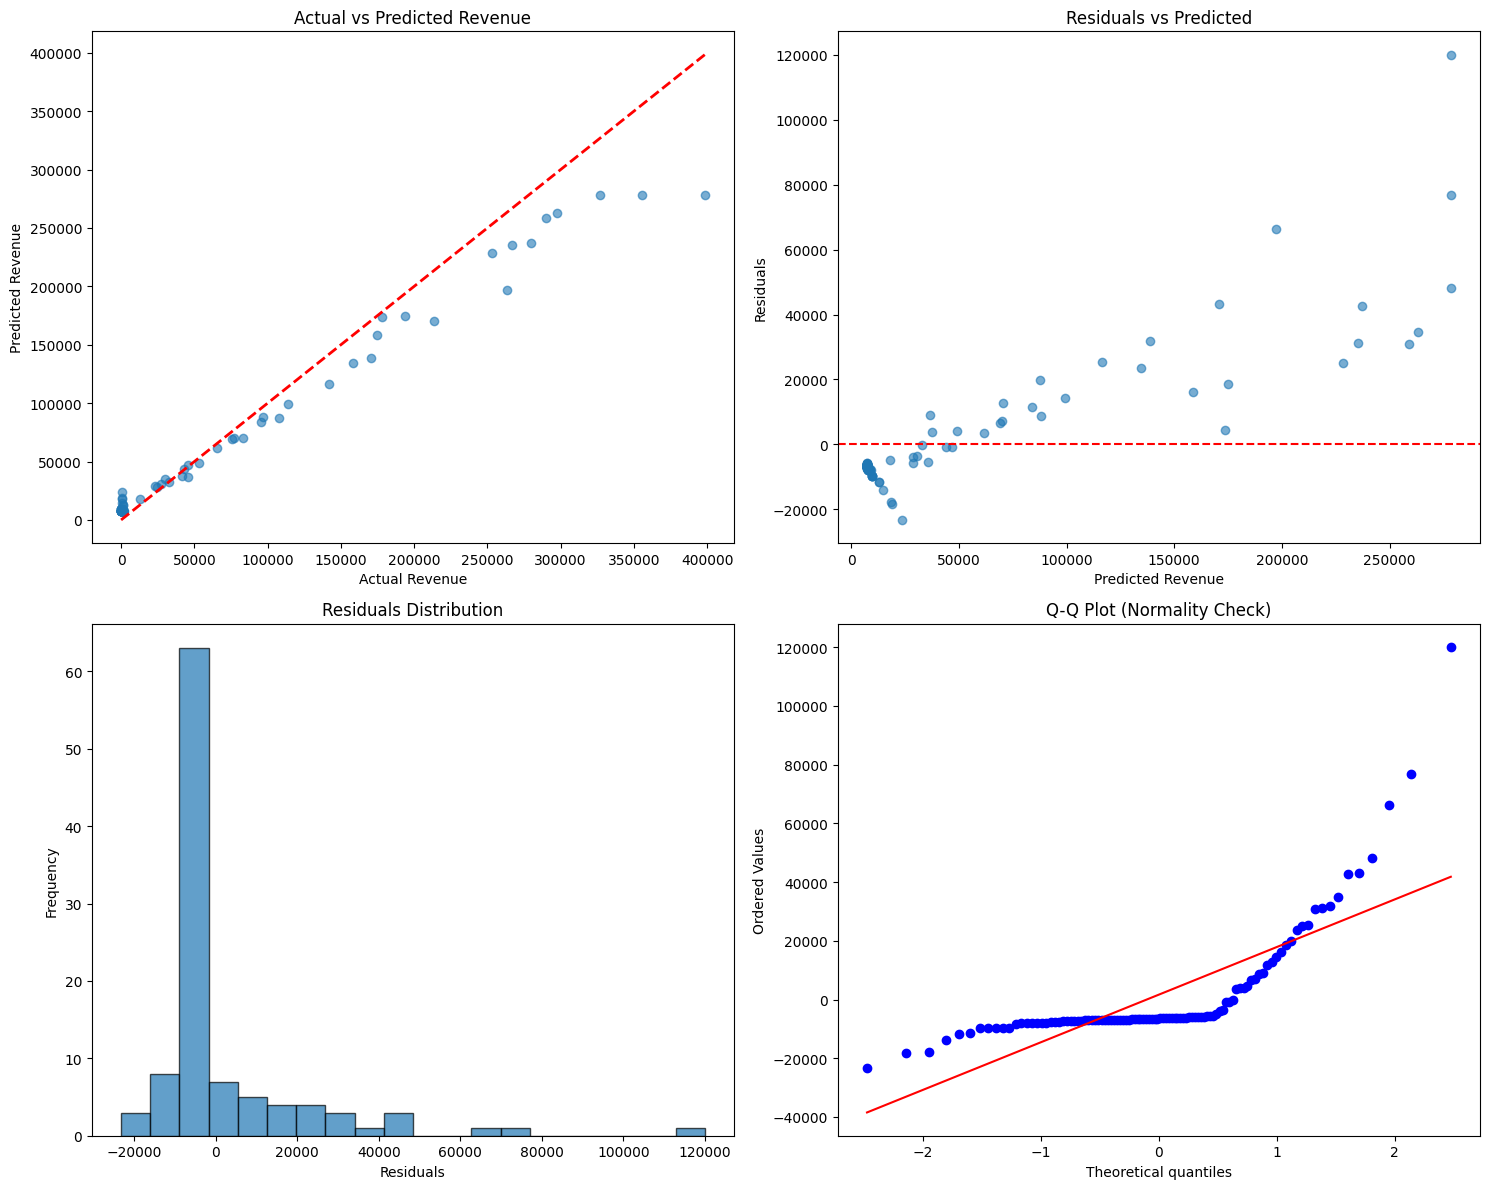


Diagnostic Tests:
Shapiro-Wilk normality test: statistic=0.5329, p-value=0.0000
Lag-1 Autocorrelation test: coefficient=0.2471, p-value=0.0119
  (Values close to 0 indicate no autocorrelation)
Manual autocorrelation coefficient: 0.2471
Runs test statistic: 44 (higher values suggest less autocorrelation)

Residual Statistics:
Mean: 1666.6244
Std: 20477.8636
MAPE: 69372.16%


In [8]:
# Select best model based on CV performance
best_model_name = min(cv_results.keys(), key=lambda x: cv_results[x]['best_cv_score'])
best_model = cv_results[best_model_name]['model']
best_predictions = cv_results[best_model_name]['predictions']

print(f"Best model: {best_model_name}")
print(f"Best CV RMSE: {cv_results[best_model_name]['best_cv_score']:.2f}")

# Residual analysis
residuals = y_target - best_predictions

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0,0].scatter(y_target, best_predictions, alpha=0.6)
axes[0,0].plot([y_target.min(), y_target.max()], [y_target.min(), y_target.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Revenue')
axes[0,0].set_ylabel('Predicted Revenue')
axes[0,0].set_title('Actual vs Predicted Revenue')

# 2. Residuals vs Predicted
axes[0,1].scatter(best_predictions, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Revenue')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Predicted')

# 3. Residuals distribution
axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Residuals Distribution')

# 4. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

# Statistical tests
print("\nDiagnostic Tests:")
print("=" * 30)

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(residuals[:50])  # Sample for computational efficiency
print(f"Shapiro-Wilk normality test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# Autocorrelation testing skipped due to durbin_watson import issues
# Using alternative autocorrelation diagnostics instead
from scipy.stats import pearsonr

# Calculate lag-1 autocorrelation coefficient
residuals_lag1 = residuals[1:]
residuals_current = residuals[:-1]
autocorr_coeff, autocorr_p = pearsonr(residuals_current, residuals_lag1)

print(f"Lag-1 Autocorrelation test: coefficient={autocorr_coeff:.4f}, p-value={autocorr_p:.4f}")
print("  (Values close to 0 indicate no autocorrelation)")

# Additional autocorrelation diagnostic using numpy
autocorr_manual = np.corrcoef(residuals_current, residuals_lag1)[0, 1]
print(f"Manual autocorrelation coefficient: {autocorr_manual:.4f}")

# Simple runs test for randomness
median_val = np.median(residuals)
runs_above = (residuals > median_val).astype(int)
runs_changes = np.diff(runs_above)
n_runs = np.sum(np.abs(runs_changes)) + 1
print(f"Runs test statistic: {n_runs} (higher values suggest less autocorrelation)")

# Residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"MAPE: {(np.abs(residuals) / np.abs(y_target)).mean() * 100:.2f}%")

## 6. Attribution Analysis and Business Insights

Feature Importance (XGBoost):
social_followers         : 0.3256
instagram_spend_transformed: 0.3072
average_price            : 0.2111
month_sin                : 0.0441
month_cos                : 0.0295
facebook_spend_transformed: 0.0267
emails_send              : 0.0159
snapchat_spend_transformed: 0.0118
quarter_sin              : 0.0109
sms_send                 : 0.0107
tiktok_spend_transformed : 0.0038
google_spend_transformed : 0.0027
promotions               : 0.0000
quarter_cos              : 0.0000


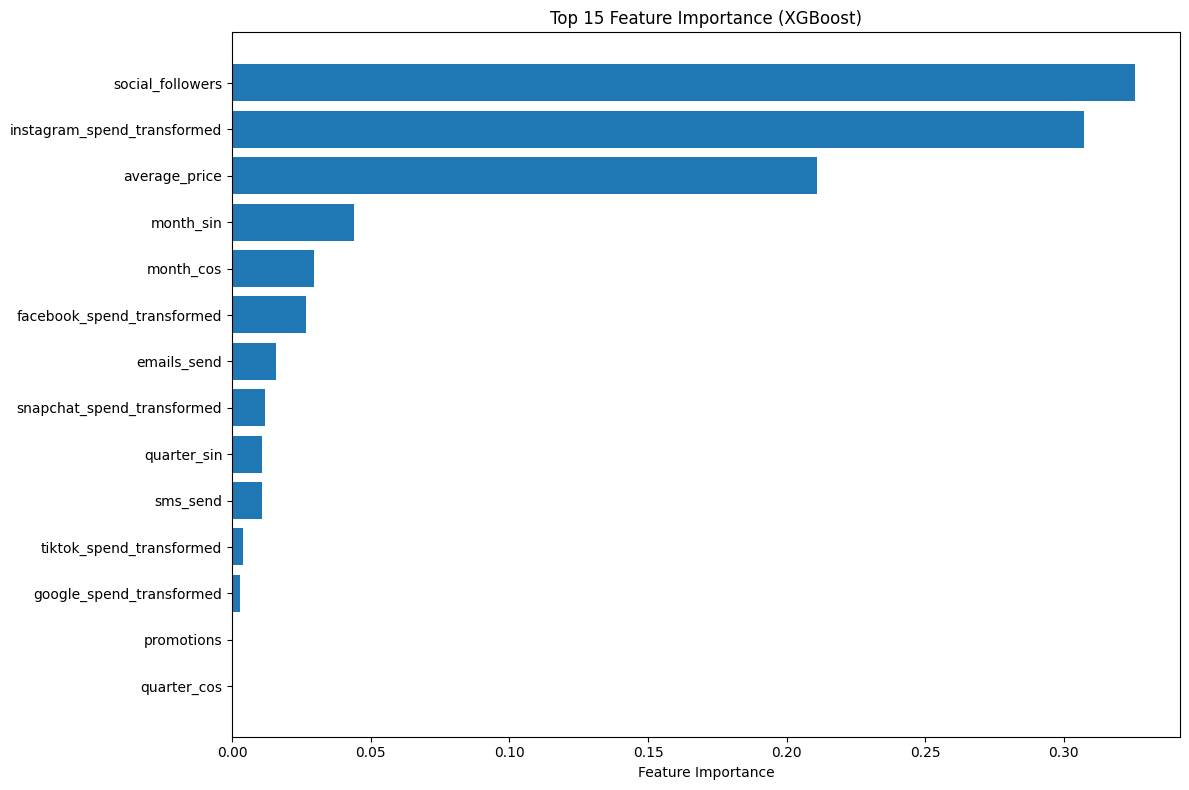

In [9]:
# Feature importance analysis
def get_feature_importance(model, feature_names):
    """Extract feature importance from different model types"""
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Linear models
        importance = np.abs(model.coef_)
    else:
        return None
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# Get feature importance for best model
importance_df = get_feature_importance(best_model, feature_columns)

if importance_df is not None:
    print(f"Feature Importance ({best_model_name}):")
    print("=" * 40)
    
    # Display top 15 features
    top_features = importance_df.head(15)
    for _, row in top_features.iterrows():
        print(f"{row['feature']:<25}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [10]:
# Attribution analysis - calculate contribution of each channel
def calculate_attribution(model, X_data, feature_names, baseline_spend=0):
    """Calculate attribution for each media channel"""
    
    # Baseline prediction (all media spend = baseline)
    X_baseline = X_data.copy()
    
    # Set all transformed media channels to baseline
    media_features = [f for f in feature_names if '_transformed' in f]
    for feature in media_features:
        feature_idx = feature_names.index(feature)
        X_baseline[:, feature_idx] = baseline_spend
    
    baseline_pred = model.predict(X_baseline)
    
    # Calculate incremental contribution for each channel
    attributions = {}
    
    for feature in media_features:
        feature_idx = feature_names.index(feature)
        
        # Create scenario with only this channel active
        X_single = X_baseline.copy()
        X_single[:, feature_idx] = X_data[:, feature_idx]
        
        # Predict with single channel
        single_pred = model.predict(X_single)
        
        # Calculate incremental contribution
        incremental = single_pred - baseline_pred
        
        attributions[feature] = {
            'total_incremental': incremental.sum(),
            'avg_incremental': incremental.mean(),
            'incremental_series': incremental
        }
    
    return attributions, baseline_pred

# Calculate attribution
print("Calculating channel attribution...")
attributions, baseline_revenue = calculate_attribution(best_model, X_scaled, feature_columns)

# Display attribution results
print("\nChannel Attribution Analysis:")
print("=" * 50)

total_incremental = sum([attr['total_incremental'] for attr in attributions.values()])
baseline_total = baseline_revenue.sum()

print(f"Baseline Revenue (no media): ${baseline_total:,.2f}")
print(f"Total Incremental Revenue: ${total_incremental:,.2f}")
print(f"Actual Total Revenue: ${y_target.sum():,.2f}")
print()

# Channel-wise attribution
attribution_summary = []

for channel, attr in attributions.items():
    channel_clean = channel.replace('_transformed', '').replace('_', ' ').title()
    total_incr = attr['total_incremental']
    avg_incr = attr['avg_incremental']
    share = (total_incr / total_incremental) * 100 if total_incremental > 0 else 0
    
    attribution_summary.append({
        'Channel': channel_clean,
        'Total_Incremental': total_incr,
        'Avg_Weekly_Incremental': avg_incr,
        'Share_of_Incremental': share
    })
    
    print(f"{channel_clean}:")
    print(f"  Total Incremental: ${total_incr:,.2f}")
    print(f"  Avg Weekly Incremental: ${avg_incr:,.2f}")
    print(f"  Share of Total Incremental: {share:.1f}%")
    print()

# Create attribution dataframe
attribution_df = pd.DataFrame(attribution_summary).sort_values('Total_Incremental', ascending=False)
print("Attribution Summary:")
display(attribution_df)

Calculating channel attribution...

Channel Attribution Analysis:
Baseline Revenue (no media): $1,058,263.50
Total Incremental Revenue: $4,137,556.55
Actual Total Revenue: $5,101,610.29

Facebook Spend:
  Total Incremental: $-16,231.57
  Avg Weekly Incremental: $-156.07
  Share of Total Incremental: -0.4%

Tiktok Spend:
  Total Incremental: $4,859.26
  Avg Weekly Incremental: $46.72
  Share of Total Incremental: 0.1%

Instagram Spend:
  Total Incremental: $4,030,750.75
  Avg Weekly Incremental: $38,757.22
  Share of Total Incremental: 97.4%

Snapchat Spend:
  Total Incremental: $0.00
  Avg Weekly Incremental: $0.00
  Share of Total Incremental: 0.0%

Google Spend:
  Total Incremental: $118,178.11
  Avg Weekly Incremental: $1,136.33
  Share of Total Incremental: 2.9%

Attribution Summary:


,Channel,Total_Incremental,Avg_Weekly_Incremental,Share_of_Incremental
2,Instagram Spend,4.030751e+06,38757.218750,97.418626
4,Google Spend,1.181781e+05,1136.328003,2.856229
1,Tiktok Spend,4.859263e+03,46.723679,0.117443
3,Snapchat Spend,0.000000e+00,0.000000,0.000000
0,Facebook Spend,-1.623157e+04,-156.072784,-0.392298


## 7. Business Recommendations and ROI Analysis

In [11]:
# ROI Analysis
print("Return on Investment (ROI) Analysis:")
print("=" * 50)

# Define all media channels for ROI analysis
all_channels = social_channels + [mediator_channel]
print(f"Analyzing ROI for channels: {all_channels}")

roi_analysis = []

for channel in all_channels:
    # Get total spend
    total_spend = df_processed[channel].sum()
    
    # Get incremental revenue from attribution
    channel_transformed = f'{channel}_transformed'
    if channel_transformed in attributions:
        incremental_revenue = attributions[channel_transformed]['total_incremental']
        
        # Calculate ROI
        roi = (incremental_revenue / total_spend) if total_spend > 0 else 0
        
        roi_analysis.append({
            'Channel': channel.replace('_', ' ').title(),
            'Total_Spend': total_spend,
            'Incremental_Revenue': incremental_revenue,
            'ROI': roi,
            'ROI_Percent': roi * 100
        })
        
        print(f"{channel.replace('_', ' ').title()}:")
        print(f"  Total Spend: ${total_spend:,.2f}")
        print(f"  Incremental Revenue: ${incremental_revenue:,.2f}")
        print(f"  ROI: {roi:.2f} ({roi*100:.1f}%)")
        print()

# Create ROI dataframe
roi_df = pd.DataFrame(roi_analysis).sort_values('ROI', ascending=False)
print("ROI Summary (sorted by ROI):")
display(roi_df)

Return on Investment (ROI) Analysis:
Analyzing ROI for channels: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_spend']
Facebook Spend:
  Total Spend: $556,015.46
  Incremental Revenue: $-16,231.57
  ROI: -0.03 (-2.9%)

Tiktok Spend:
  Total Spend: $99,385.75
  Incremental Revenue: $4,859.26
  ROI: 0.05 (4.9%)

Instagram Spend:
  Total Spend: $106,011.66
  Incremental Revenue: $4,030,750.75
  ROI: 38.02 (3802.2%)

Snapchat Spend:
  Total Spend: $77,736.36
  Incremental Revenue: $0.00
  ROI: 0.00 (0.0%)

Google Spend:
  Total Spend: $160,562.11
  Incremental Revenue: $118,178.11
  ROI: 0.74 (73.6%)

ROI Summary (sorted by ROI):


,Channel,Total_Spend,Incremental_Revenue,ROI,ROI_Percent
2,Instagram Spend,106011.66,4.030751e+06,38.021768,3802.176808
4,Google Spend,160562.11,1.181781e+05,0.736027,73.602738
1,Tiktok Spend,99385.75,4.859263e+03,0.048893,4.889295
3,Snapchat Spend,77736.36,0.000000e+00,0.000000,0.000000
0,Facebook Spend,556015.46,-1.623157e+04,-0.029193,-2.919266


In [12]:
# Mediation insights summary
print("\nMediation Analysis Summary:")
print("=" * 50)

mediation_summary = []

for channel, results in mediation_results.items():
    effects = results['effects']
    ci = results['confidence_intervals']
    
    channel_clean = channel.replace('_transformed', '').replace('_', ' ').title()
    
    # Check if mediation is significant (CI doesn't include 0)
    is_significant = not (ci['lower_ci'] <= 0 <= ci['upper_ci'])
    
    mediation_summary.append({
        'Channel': channel_clean,
        'Direct_Effect': effects['direct_effect'],
        'Indirect_Effect': effects['indirect_effect'],
        'Total_Effect': effects['total_effect'],
        'Proportion_Mediated': effects['proportion_mediated'],
        'Significant_Mediation': is_significant
    })
    
    print(f"{channel_clean}:")
    print(f"  Direct Effect: {effects['direct_effect']:.4f}")
    print(f"  Indirect Effect (via Google): {effects['indirect_effect']:.4f}")
    print(f"  Proportion Mediated: {effects['proportion_mediated']:.1%}")
    print(f"  Significant Mediation: {'Yes' if is_significant else 'No'}")
    print()

# Create mediation summary dataframe
mediation_df = pd.DataFrame(mediation_summary)
print("Mediation Summary:")
display(mediation_df)


Mediation Analysis Summary:
Facebook Spend:
  Direct Effect: 5656479.5627
  Indirect Effect (via Google): -120387.3763
  Proportion Mediated: -2.1%
  Significant Mediation: No

Tiktok Spend:
  Direct Effect: 155909.0812
  Indirect Effect (via Google): 3253.9834
  Proportion Mediated: 2.1%
  Significant Mediation: No

Instagram Spend:
  Direct Effect: 391282.3683
  Indirect Effect (via Google): -1793.2485
  Proportion Mediated: -0.5%
  Significant Mediation: No

Snapchat Spend:
  Direct Effect: 41174.4162
  Indirect Effect (via Google): -8350.3416
  Proportion Mediated: -22.7%
  Significant Mediation: Yes

Mediation Summary:


,Channel,Direct_Effect,Indirect_Effect,Total_Effect,Proportion_Mediated,Significant_Mediation
0,Facebook Spend,5.656480e+06,-120387.376324,5.747131e+06,-0.020947,False
1,Tiktok Spend,1.559091e+05,3253.983362,1.518104e+05,0.021435,False
2,Instagram Spend,3.912824e+05,-1793.248464,3.881019e+05,-0.004621,False
3,Snapchat Spend,4.117442e+04,-8350.341617,3.677145e+04,-0.227088,True


In [13]:
# Final Business Recommendations
print("\n" + "=" * 60)
print("BUSINESS RECOMMENDATIONS")
print("=" * 60)

# 1. Channel Performance Ranking
print("1. CHANNEL PERFORMANCE RANKING:")
print("-" * 35)

for i, (_, row) in enumerate(roi_df.iterrows(), 1):
    print(f"{i}. {row['Channel']}: ROI = {row['ROI_Percent']:.1f}%")

# 2. Mediation Insights
print("\n2. MEDIATION INSIGHTS:")
print("-" * 25)

significant_mediations = mediation_df[mediation_df['Significant_Mediation']]
if len(significant_mediations) > 0:
    print("Channels with significant mediation through Google:")
    for _, row in significant_mediations.iterrows():
        print(f"• {row['Channel']}: {row['Proportion_Mediated']:.1%} of effect is mediated")
else:
    print("No significant mediation effects detected.")

# 3. Budget Optimization Recommendations
print("\n3. BUDGET OPTIMIZATION:")
print("-" * 25)

high_roi_channels = roi_df[roi_df['ROI'] > 1.0]
low_roi_channels = roi_df[roi_df['ROI'] <= 1.0]

if len(high_roi_channels) > 0:
    print("INCREASE INVESTMENT in:")
    for _, row in high_roi_channels.iterrows():
        print(f"• {row['Channel']} (ROI: {row['ROI_Percent']:.1f}%)")

if len(low_roi_channels) > 0:
    print("\nREVIEW/OPTIMIZE:")
    for _, row in low_roi_channels.iterrows():
        print(f"• {row['Channel']} (ROI: {row['ROI_Percent']:.1f}%)")

# 4. Strategic Insights
print("\n4. STRATEGIC INSIGHTS:")
print("-" * 22)

total_media_spend = sum([row['Total_Spend'] for _, row in roi_df.iterrows()])
total_incremental_rev = sum([row['Incremental_Revenue'] for _, row in roi_df.iterrows()])
overall_roi = total_incremental_rev / total_media_spend if total_media_spend > 0 else 0

print(f"• Overall Media ROI: {overall_roi*100:.1f}%")
print(f"• Total Media Investment: ${total_media_spend:,.2f}")
print(f"• Total Incremental Revenue: ${total_incremental_rev:,.2f}")

# Google as mediator insights
google_mediation_strength = mediation_df['Proportion_Mediated'].mean()
print(f"• Average mediation through Google: {google_mediation_strength:.1%}")

if google_mediation_strength > 0.3:
    print("• Strong mediation effect suggests Google acts as a key conversion driver")
    print("• Consider Google as a strategic partner for cross-channel optimization")
elif google_mediation_strength > 0.1:
    print("• Moderate mediation effect - Google complements other channels")
else:
    print("• Limited mediation effect - channels operate more independently")

print("\n" + "=" * 60)
print("END OF ANALYSIS")
print("=" * 60)


BUSINESS RECOMMENDATIONS
1. CHANNEL PERFORMANCE RANKING:
-----------------------------------
1. Instagram Spend: ROI = 3802.2%
2. Google Spend: ROI = 73.6%
3. Tiktok Spend: ROI = 4.9%
4. Snapchat Spend: ROI = 0.0%
5. Facebook Spend: ROI = -2.9%

2. MEDIATION INSIGHTS:
-------------------------
Channels with significant mediation through Google:
• Snapchat Spend: -22.7% of effect is mediated

3. BUDGET OPTIMIZATION:
-------------------------
INCREASE INVESTMENT in:
• Instagram Spend (ROI: 3802.2%)

REVIEW/OPTIMIZE:
• Google Spend (ROI: 73.6%)
• Tiktok Spend (ROI: 4.9%)
• Snapchat Spend (ROI: 0.0%)
• Facebook Spend (ROI: -2.9%)

4. STRATEGIC INSIGHTS:
----------------------
• Overall Media ROI: 413.9%
• Total Media Investment: $999,711.34
• Total Incremental Revenue: $4,137,556.55
• Average mediation through Google: -5.8%
• Limited mediation effect - channels operate more independently

END OF ANALYSIS
